In [1]:
import numpy as np
import pystan
import arviz
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from collections import OrderedDict

def pystan_vb_extract(results):
    param_specs = results['sampler_param_names']
    samples = results['sampler_params']
    n = len(samples[0])

    # first pass, calculate the shape
    param_shapes = OrderedDict()
    for param_spec in param_specs:
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) for i in splt[1][:-1].split(',')]  # no +1 for shape calculation because pystan already returns 1-based indexes for vb!
        else:
            idxs = ()
        param_shapes[name] = np.maximum(idxs, param_shapes.get(name, idxs))

    # create arrays
    params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])

    # second pass, set arrays
    for param_spec, param_samples in zip(param_specs, samples):
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) - 1 for i in splt[1][:-1].split(',')]  # -1 because pystan returns 1-based indexes for vb!
        else:
            idxs = ()
        params[name][(..., ) + tuple(idxs)] = param_samples

    return params

In [3]:
extracted_coefficients_directory = '../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)
n = B_zeta.shape[0]
p = B_zeta.shape[1]
X = B_zeta

In [4]:
hmc_code = '''


functions {
    vector S_xtheta(real tau2, matrix X, int p, int n) {
        vector[n] s_is;
        for (N in 1:n) {
          s_is[N] = 1/sqrt(1 + tau2*sum(square(row(X, N)))); 
        } 
        return(s_is);
    }
    
    real scaledepprior_lpdf(real tau2 ) {
        real pdf;
        pdf = log(1/2.5) -0.5*log(tau2/2.5) - sqrt(tau2/2.5);
        return(pdf);
    }

    }
data {
  int<lower=1> n; // Number of data
  int<lower=1> p; // Number of covariates
  matrix[n,p] X;  // n-by-p design matrix
  real y[n];      // n-dimensional response vector
}


parameters {
  vector[p] beta;
  real<lower=0> tau2;
}

transformed parameters {
  vector[n] theta ;
  vector[n] S ;
  vector[n] Var ;
  S = S_xtheta(tau2, X, p, n);
  theta = S .* (X * beta);
  Var = square(S);
}

model {
  tau2 ~ scaledepprior();
  beta ~ normal(0, tau2); 
  y ~ normal(theta, Var);
}'''

In [5]:
hmc_dat = {'n': n,
           'p': p,
           'X': X,
           'y': z}

In [6]:
sm = pystan.StanModel(model_code = hmc_code, verbose = True)
print('finished compiling')
print('start sampling')
fit = sm.sampling(data = hmc_dat,
                  iter = 1000, 
                  chains = 4, 
                  verbose = True)
print('finished sampling')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fd503ee02964fc20c9d017c0a17ad0c5 NOW.
INFO:pystan:OS: linux, Python: 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], Cython 0.29.21


Compiling /tmp/pystan_nww30ehv/stanfit4anon_model_fd503ee02964fc20c9d017c0a17ad0c5_7721671613585950118.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_nww30ehv/stanfit4anon_model_fd503ee02964fc20c9d017c0a17ad0c5_7721671613585950118.pyx
building 'stanfit4anon_model_fd503ee02964fc20c9d017c0a17ad0c5_7721671613585950118' extension
creating /tmp/pystan_nww30ehv/tmp
creating /tmp/pystan_nww30ehv/tmp/pystan_nww30ehv
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_nww30ehv -I/home/hofmancl/.local/lib/python3.8/site-packages/pystan -I/home/hofmancl/.local/lib/python3.8/site-packages/pystan/stan/src -I/home/hofmancl/.local/lib/python3.8/site-packages/pystan/stan/lib/stan_math -I/home/hofman

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


finished sampling


In [7]:
#la = fit.extract(permuted=True) 
la = fit.extract(permuted=True)

In [ ]:
vb_fit = sm.vb(data = hmc_dat, verbose = True)

In [ ]:
res = pystan_vb_extract(vb_fit)

In [ ]:
betas_vb = np.mean(res['beta'], axis = 0)
taus_vb = np.mean(res['tau2'], axis = 0)
betas_vb_sd = np.std(res['beta'], axis = 0)
taus_vb_sd = np.std(res['tau2'], axis = 0)

In [ ]:
#pystan.check_hmc_diagnostics(fit)

In [ ]:
import pickle

In [ ]:
with open('ridge_hmc_500.p', 'wb') as handle:
    pickle.dump(la['beta', 'tau2'], handle, protocol=pickle.HIGHEST_PROTOCOL)

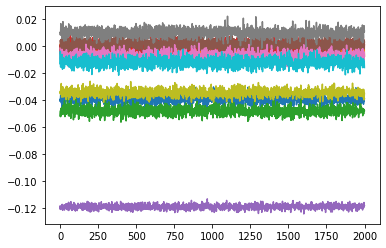

In [8]:
plt.plot(la['beta'])

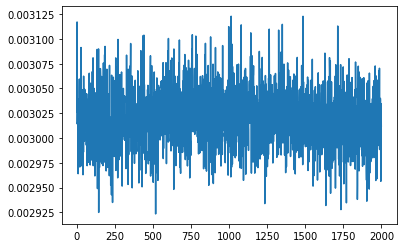

In [9]:
plt.plot(la['tau2'])

In [ ]:
arviz.plot_trace(fit)

In [10]:
betas = np.mean(la['beta'], axis = 0)
betas_sd = np.std(la['beta'], axis = 0)

In [11]:
betas_sd

array([0.00278659, 0.00280209, 0.00266964, 0.00294803, 0.00156676,
       0.00292545, 0.00284557, 0.00286371, 0.00243715, 0.00302508])

In [ ]:
tau = np.mean(np.log(la['tau2']), axis = 0)
tau_sd = np.std(np.log(la['tau2']), axis = 0)

In [ ]:
mu_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/mu_ts23.npy')
mu_ts_m = np.mean(mu_ts.reshape(10000, 11)[9500:,:], axis = 0)
B_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/B_ts23.npy')
d_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/d_ts23.npy')
B_ts = np.mean(B_ts[9500:,:,:], axis = 0)
d_ts = np.mean(d_ts[9500:,:,:], axis = 0)
#var = np.genfromtxt('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/Var.csv', delimiter = ',')
#va_sd = np.sqrt(np.diag(var))
va_sd = np.sqrt(np.diag((B_ts.dot(B_ts.T) + d_ts**2)))

In [ ]:
mu_ts.shape

In [ ]:
mu_ts.shape

In [ ]:
plt.scatter(mu_ts_m[0:10], betas)
plt.scatter(np.exp(mu_ts_m[10]), np.exp(tau))
ident = [-.5, .5]
plt.plot(ident,ident)

In [ ]:
plt.scatter(betas_vb[0:10], betas)
ident = [-.5, .5]
plt.plot(ident,ident)

In [ ]:
plt.scatter(betas_vb_sd[0:10], betas_sd)
ident = [0, .005]
plt.plot(ident,ident)

In [ ]:
plt.scatter(va_sd[0:10], betas_sd)
plt.scatter(va_sd[10], tau_sd)
ident = [0, .05]
plt.plot(ident,ident)

In [ ]:
plt.scatter(va_sd[0:10], betas_sd)
plt.scatter(va_sd[10], tau_sd)
ident = [0, .05]
plt.plot(ident,ident)

In [ ]:
plt.scatter(va_sd[0:10], betas_sd)
plt.scatter(va_sd[10], tau_sd)
ident = [0, .01]
plt.plot(ident,ident)

In [ ]:
plt.scatter(mu_ts_m[10], tau)
ident = [0, .5]
plt.plot(ident,ident)

In [ ]:
plt.scatter(np.exp(0.5*mu_ts_m[10:20]), lambdas)
ident = [-.5, .5]
plt.plot(ident,ident)

In [ ]:
plt.scatter(np.exp(mu_ts_m[20]), tau)
ident = [-.5, .5]
plt.plot(ident,ident)

In [ ]:
plt.scatter(va_sd[20], tau_sd)
ident = [0, .5]
plt.plot(ident,ident)

In [ ]:
all_thetas = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/all_thetas_L100.npy')

In [ ]:
plt.plot(all_thetas[:])
plt.ylim(-1,1)


In [ ]:
df = np.array(all_thetas)

In [ ]:
plt.scatter(mu_ts_m[0:10], np.mean(df[100:,0:10], axis = 0))
#plt.scatter(mu_ts_m[10], np.mean(df[2000:,10], axis = 0))
ident = [-.5, .5]
plt.plot(ident,ident)

In [ ]:
plt.scatter(va_sd[0:10], np.std(df[500:,0:10], axis = 0))
plt.scatter(va_sd[10], np.std(df[500:,10], axis = 0))
ident = [0, .1]
plt.plot(ident,ident)

In [ ]:
np.std(df[100:,0:10], axis = 0)